## Primary Task 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf) 

In [2]:
def arrival_time(lambda_):
    return np.random.exponential(1 / lambda_)

In [3]:
def time_of_stay(mu):
    return np.random.exponential(mu)

In [4]:
def simulate_arrival_time_day(lambda_, days_simulation):

    total = 0
    arrivals_time = []

    while total < days_simulation:
        time_arrival = arrival_time(lambda_)
        arrivals_time.append(time_arrival)

        total += time_arrival

    return np.array(np.cumsum(arrivals_time))

In [5]:
def extract_new_ward(patient, transition_probability):

    possible_wards = np.arange(0, transition_probability.shape[0])
    new_ward = np.random.choice(possible_wards, p=transition_probability[patient, : ])

    return new_ward

In [6]:
def list_arrive_patient(arrivals_time):
    result = []
    for idx, sublist in enumerate(arrivals_time):
        for value in sublist:
            result.append((value, idx))
    
    # Sort by arrival time (first element of tuple)
    result.sort()
    return result

In [7]:
def count_new_departures(leaving_time, processed, current_time, n_types):
    departures_count = [0] * n_types

    for i, (t, p_type) in enumerate(leaving_time):
        if not processed[i] and t < current_time:
            departures_count[p_type] += 1
            processed[i] = True  # mark as processed

    return departures_count, processed

In [8]:
def simulate(
    transition_probability,
    lambdas,
    mean_length_stay,
    bed_capacity,
    days_simulation
):
    n_types = len(lambdas)
    type_patients = np.arange(n_types)

    occupied_bed = np.zeros(n_types, dtype=int)
    rejected_patients = np.zeros(n_types, dtype=int)

    # Time-tracking
    occupied_bed_timeline = []
    rejected_patients_timeline = []
    time_timeline = []

    # Relocation tracking: [original_type, relocated_to]
    relocated_patients = np.zeros((n_types, n_types), dtype=int)

    # Simulate arrivals per type
    arrival_time_total = [
        simulate_arrival_time_day(lambdas[tp], days_simulation)
        for tp in type_patients
    ]
    mix_arrivals_time = list_arrive_patient(arrival_time_total)
    # Leave tracking
    leaving_time = []
    processed = []

    for arrival_time, patient_type in mix_arrivals_time:
        # Discharge patients whose time has come
        departures_count, processed = count_new_departures(
            leaving_time, processed, arrival_time, n_types
        )
        occupied_bed -= departures_count

        # Try to admit to primary ward
        if occupied_bed[patient_type] < bed_capacity[patient_type]:
            occupied_bed[patient_type] += 1
            stay_time = time_of_stay(mean_length_stay[patient_type])
            departure_time = arrival_time + stay_time
            leaving_time.append((departure_time, patient_type))
            processed.append(False)
        else:
            # Try redirecting
            new_ward = extract_new_ward(patient_type, transition_probability)

            if occupied_bed[new_ward] < bed_capacity[new_ward]:
                occupied_bed[new_ward] += 1
                stay_time = time_of_stay(mean_length_stay[new_ward])
                departure_time = arrival_time + stay_time
                leaving_time.append((departure_time, new_ward))
                processed.append(False)

                # Track relocation from original type to new ward
                relocated_patients[patient_type, new_ward] += 1
            else:
                rejected_patients[patient_type] += 1

        # Record snapshot
        occupied_bed_timeline.append(occupied_bed.copy())
        rejected_patients_timeline.append(rejected_patients.copy())
        time_timeline.append(arrival_time)

    return (
        np.array(occupied_bed_timeline),
        np.array(rejected_patients_timeline),
        np.array(time_timeline),
        leaving_time,
        relocated_patients,
        mix_arrivals_time
    )


In [9]:

P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80],  # From A
    [0.20, 0.00, 0.50, 0.15, 0.15],  # From B
    [0.30, 0.20, 0.00, 0.20, 0.30],  # From C
    [0.35, 0.30, 0.05, 0.00, 0.30],  # From D
    [0.20, 0.10, 0.60, 0.10, 0.00],  # From E
])

bed_capacities = [55, 40, 30, 20, 20]

lambdas = [14.5, 11.0, 8.0, 6.5, 5.0]

mean_length_of_stay = np.array([2.9, 4.0, 4.5, 1.4, 3.9])

days_simulation = 100

In [10]:
occ_bed_hist, rej_hist, time_hist, leaves, reloc_matrix, mix_time_arrival = simulate(P, lambdas, mean_length_of_stay, bed_capacities, days_simulation)

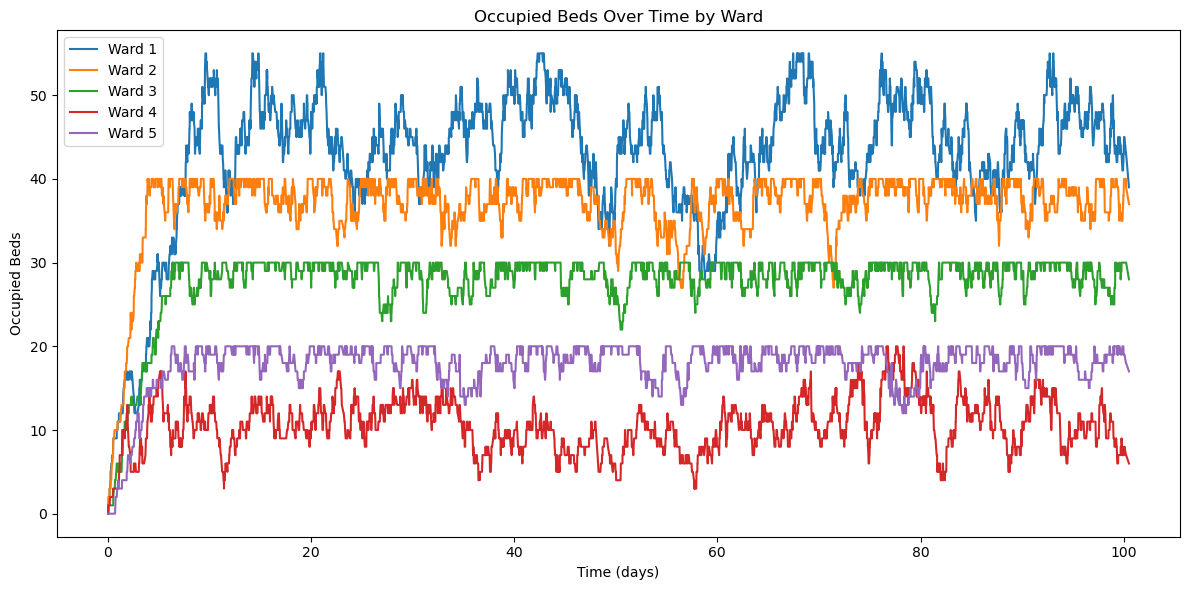

In [11]:
plt.figure(figsize=(12, 6))
for i in range(occ_bed_hist.shape[1]):
    plt.plot(time_hist, occ_bed_hist[:, i], label=f"Ward {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Occupied Beds")
plt.title("Occupied Beds Over Time by Ward")
plt.legend()
plt.tight_layout()
plt.show()

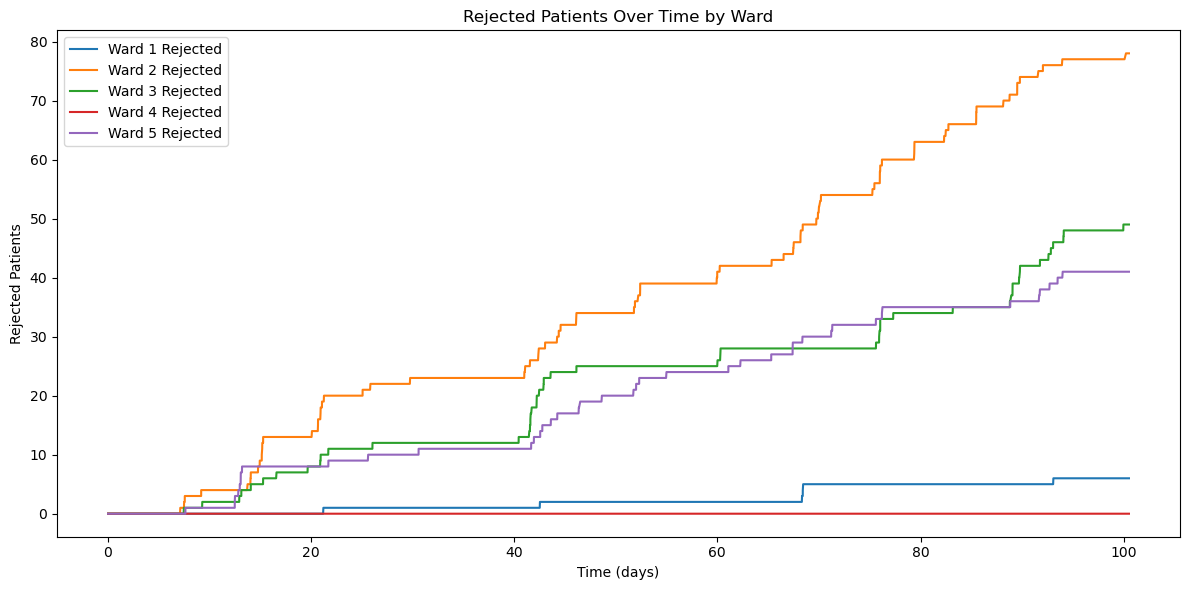

In [12]:
plt.figure(figsize=(12, 6))
for i in range(rej_hist.shape[1]):
    plt.plot(time_hist, rej_hist[:, i], label=f"Ward {i+1} Rejected")
plt.xlabel("Time (days)")
plt.ylabel("Rejected Patients")
plt.title("Rejected Patients Over Time by Ward")
plt.legend()
plt.tight_layout()
plt.show()

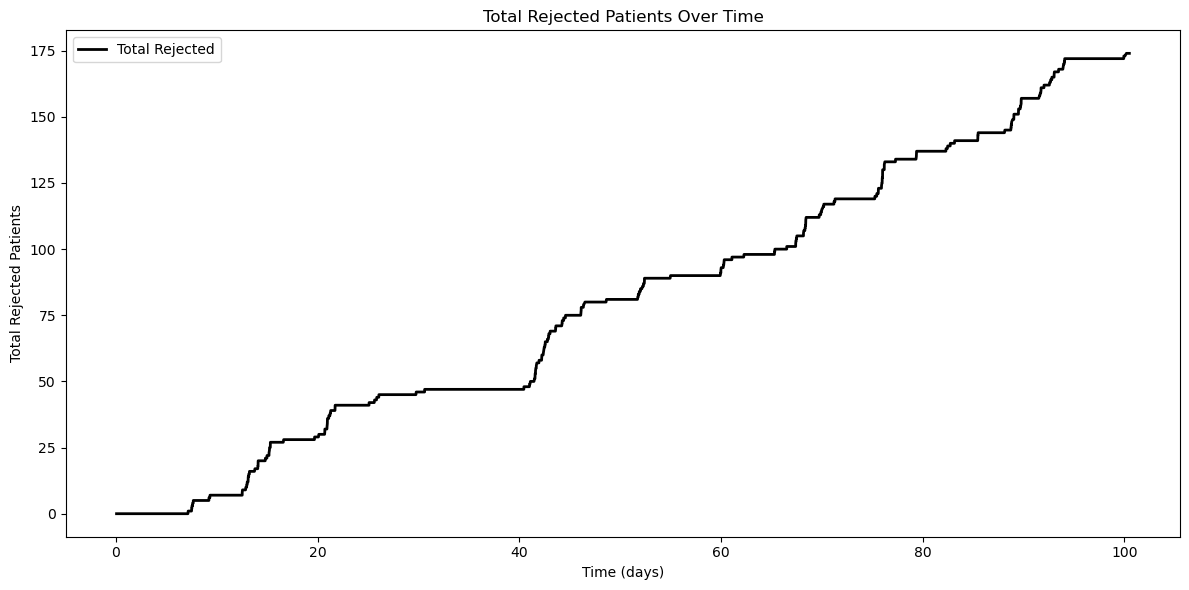

In [13]:
plt.figure(figsize=(12, 6))
total_rejected = rej_hist.sum(axis=1)
plt.plot(time_hist, total_rejected, label="Total Rejected", color="black", linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Total Rejected Patients")
plt.title("Total Rejected Patients Over Time")
plt.legend()
plt.tight_layout()
plt.show()

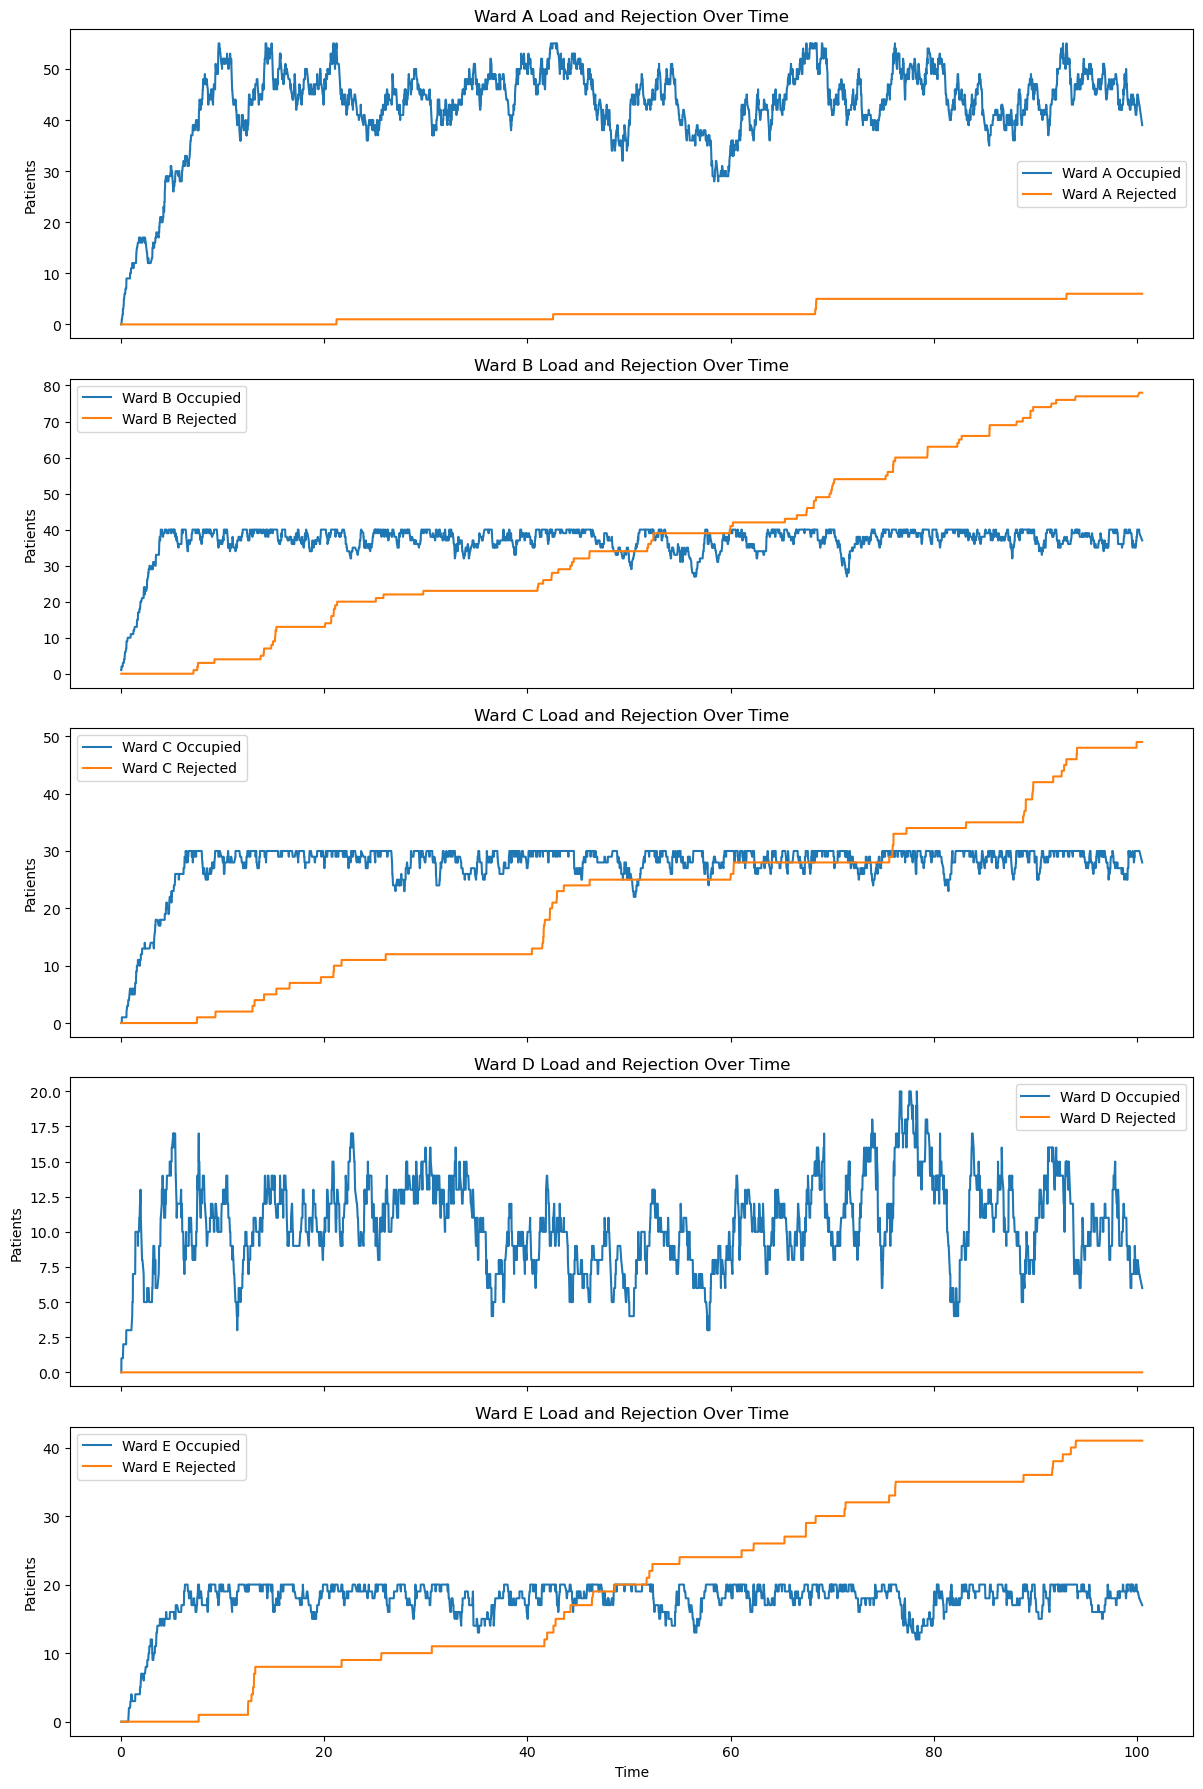

In [14]:
fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True)
ward_names = ['A', 'B', 'C', 'D', 'E']

for idx in range(5):
    axes[idx].plot(time_hist, occ_bed_hist[:, idx], label=f'Ward {ward_names[idx]} Occupied')
    axes[idx].plot(time_hist, rej_hist[:, idx], label=f'Ward {ward_names[idx]} Rejected')
    axes[idx].set_ylabel("Patients")
    axes[idx].set_title(f"Ward {ward_names[idx]} Load and Rejection Over Time")
    axes[idx].legend()

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [15]:
print(reloc_matrix)

[[ 0  0  0  2  8]
 [51  0 71 37 25]
 [88 37  0 49 68]
 [ 2  0  0  0  0]
 [31  7 44 23  0]]


In [16]:
def compute_empirical_transition(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    empirical_prob = matrix / row_sums
    return empirical_prob

In [17]:
print(compute_empirical_transition(reloc_matrix))

[[0.         0.         0.         0.2        0.8       ]
 [0.27717391 0.         0.38586957 0.20108696 0.13586957]
 [0.36363636 0.15289256 0.         0.20247934 0.28099174]
 [1.         0.         0.         0.         0.        ]
 [0.2952381  0.06666667 0.41904762 0.21904762 0.        ]]


## Primary Task 2

We need to find the minimum number of beds to give to ward F in order to have an acceptance rate of 95%

To do so, we use Erlang's-B formula 
A = lams * mean service time = 13.0 * 2.2
To use the formula to compute the probability of blocking, and we should make sure that the the probabily of blocking is less the 5%


In [18]:
from scipy.special import factorial

lam = 13.0
mean_length = 2.2
A = lam * mean_length
m_vector = np.arange(10,50)

def block_prob(A, m):
    nominator = A ** m / (factorial(m))
    denominator =  sum(A**i/factorial(i) for i in range(0,m+1))
    return nominator / denominator

for m in m_vector:
    p = block_prob(A,m)
    print(f'Probability of blocking with {m} beds is: {p}')
    if p <= 0.05:
        print(f'found p = {p} => number of beds = {m}')
        break

Probability of blocking with 10 beds is: 0.6667154065199613
Probability of blocking with 11 beds is: 0.6341633024939435
Probability of blocking with 12 beds is: 0.60181929363769
Probability of blocking with 13 beds is: 0.5697078539138748
Probability of blocking with 14 beds is: 0.5378568615721447
Probability of blocking with 15 beds is: 0.5062980933615348
Probability of blocking with 16 beds is: 0.4750677776679584
Probability of blocking with 17 beds is: 0.4442072052218292
Probability of blocking with 18 beds is: 0.41376339088674924
Probability of blocking with 19 beds is: 0.3837897722685502
Probability of blocking with 20 beds is: 0.3543469196183506
Probability of blocking with 21 beds is: 0.325503215817002
Probability of blocking with 22 beds is: 0.2973354442840266
Probability of blocking with 23 beds is: 0.2699291960117923
Probability of blocking with 24 beds is: 0.24337897506199982
Probability of blocking with 25 beds is: 0.21778784695106335
Probability of blocking with 26 beds is:

In [19]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0],  # From A
    [0.20, 0.00, 0.50, 0.15, 0.15, 0],  # From B
    [0.30, 0.20, 0.00, 0.20, 0.30, 0],  # From C
    [0.35, 0.30, 0.05, 0.00, 0.30, 0],  # From D
    [0.20, 0.10, 0.60, 0.10, 0.00, 0],  # From E
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
])

total_bed = 165

lambdas = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length_of_stay = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]

urgency_point = [7, 5, 2, 10, 5]

days_simulation = 100

In [20]:
def generate_integer_list_with_fixed_sum_and_last(n, target_sum, fixed_last):
    if n < 2:
        raise ValueError("List must have at least 2 elements.")
    if fixed_last > target_sum:
        raise ValueError("fixed_last cannot be greater than target_sum.")
    
    remaining = target_sum - fixed_last

    values = np.random.multinomial(remaining, [1/(n-1)]*(n-1))

    return list(values) + [fixed_last]

In [21]:
import random

def perturb_integer_list_keep_sum_and_last(lst, epsilon=4):

    if len(lst) < 2:
        raise ValueError("List must have at least 2 elements.")

    new_lst = lst.copy()
    n = len(new_lst)

    # Try up to 100 times to find a valid perturbation
    for _ in range(100):
        i, j = random.sample(range(n - 1), 2)

        max_decrease = min(epsilon, new_lst[i])
        if max_decrease > 0:
            delta = random.randint(1, max_decrease)
            new_lst[i] -= delta
            new_lst[j] += delta
            return new_lst

    raise RuntimeError("Unable to find a valid integer perturbation.")

In [22]:
def compute_cost(rej_hist, reloc_matrix, urgency_point):
    
    rejected = rej_hist[-1, :-1]  # exclude F*
    relocated = np.sum(reloc_matrix[:-1, :], axis=1)
    return (rejected + relocated) @ urgency_point

In [23]:
def cooling_scheme(k):
    return 1 / np.sqrt(1 + k)

In [24]:
def simulated_annealing(
    initial_combination,
    simulate,
    P, lambdas, mean_length_of_stay,
    urgency_point,
    days_simulation,
    n_iterations=1000,
    epsilon=10
):
    # Initial simulation and cost
    occ_bed_hist, rej_hist, _, _, reloc_matrix, _ = simulate(
        P, lambdas, mean_length_of_stay, initial_combination, days_simulation
    )
    initial_cost = compute_cost(rej_hist, reloc_matrix, urgency_point)

    bed_alloc_guess = initial_combination.copy()
    combination = initial_combination.copy()
    cost = [initial_cost]
    best_combination = initial_combination.copy()
    best_cost = initial_cost
    best_occ_bed_hist = occ_bed_hist
    best_rej_hist = rej_hist
    best_reloc_matrix = reloc_matrix

    for sim in range(n_iterations):
        T = cooling_scheme(sim)

        # Propose new allocation
        new_proposal = perturb_integer_list_keep_sum_and_last(bed_alloc_guess, epsilon)

        # Simulate with proposed allocation
        occ_bed_hist_new, rej_hist_new, _, _, reloc_matrix_new, _ = simulate(
            P, lambdas, mean_length_of_stay, new_proposal, days_simulation
        )

        total_penalty_new = compute_cost(rej_hist_new, reloc_matrix_new, urgency_point)

        # Acceptance decision
        diff_energy = total_penalty_new - cost[-1]
        u = np.random.uniform()

        if diff_energy <= 0 or u < np.exp(-diff_energy / T):
            bed_alloc_guess = new_proposal
            combination = new_proposal.copy()
            cost.append(total_penalty_new)

            if total_penalty_new < best_cost:
                best_cost = total_penalty_new
                best_combination = new_proposal.copy()
                best_occ_bed_hist = occ_bed_hist_new
                best_rej_hist = rej_hist_new
                best_reloc_matrix = reloc_matrix_new
        else:
            cost.append(cost[-1])  # keep previous cost

    return (
        best_combination,
        best_cost,
        cost,
        best_occ_bed_hist,
        best_rej_hist,
        best_reloc_matrix,
    )


Initial bed allocation: [np.int64(28), np.int64(22), np.int64(24), np.int64(33), np.int64(24), 34]
Total bed capacities: 165
Best bed allocation found: [np.int64(62), np.int64(44), np.int64(0), np.int64(15), np.int64(10), 34]
Best cost achieved: 4845


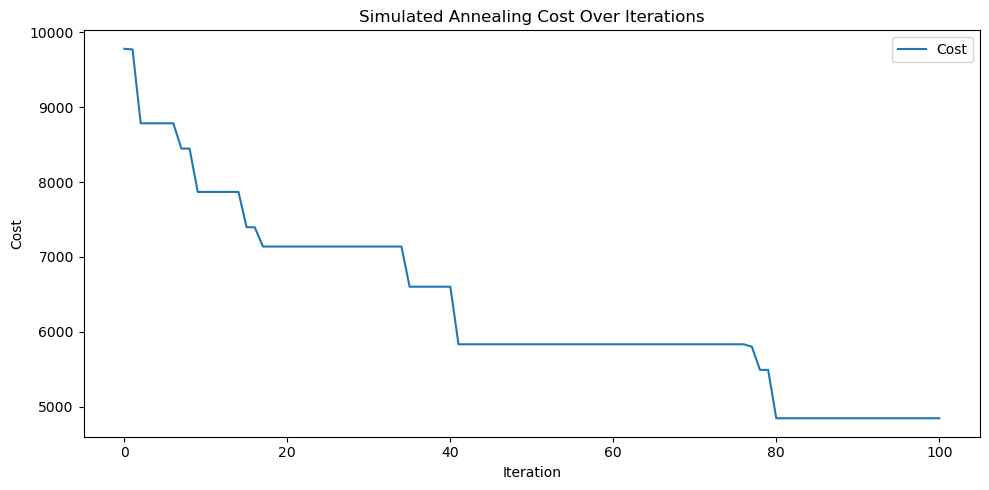

In [32]:
n = P.shape[0]

initial_combination = generate_integer_list_with_fixed_sum_and_last(n, total_bed, 34)

#initial_combination = [54, 53, 1, 18, 5, 34]

print("Initial bed allocation:", initial_combination)
print("Total bed capacities:", sum(initial_combination))

best_combination, best_cost, cost, best_occ_bed_hist, best_rej_hist, best_reloc_matrix = simulated_annealing(
    initial_combination,
    simulate,
    P, lambdas, mean_length_of_stay,
    urgency_point,
    days_simulation = 100,
    n_iterations = 100,
    epsilon = 11
)

print("Best bed allocation found:", best_combination)
print("Best cost achieved:", best_cost)

plt.figure(figsize=(10, 5))
plt.plot(cost, label="Cost")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Simulated Annealing Cost Over Iterations")
plt.legend()
plt.tight_layout()
plt.show()

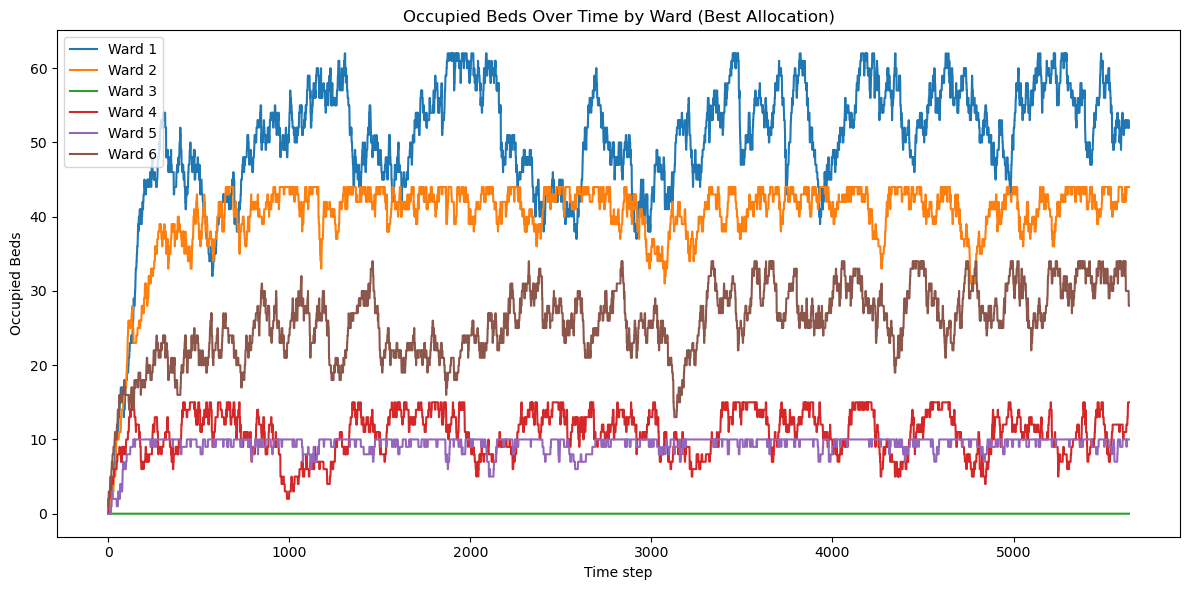

In [33]:
plt.figure(figsize=(12, 6))
for i in range(best_occ_bed_hist.shape[1]):
    plt.plot(best_occ_bed_hist[:, i], label=f"Ward {i+1}")
plt.xlabel("Time step")
plt.ylabel("Occupied Beds")
plt.title("Occupied Beds Over Time by Ward (Best Allocation)")
plt.legend()
plt.tight_layout()
plt.show()

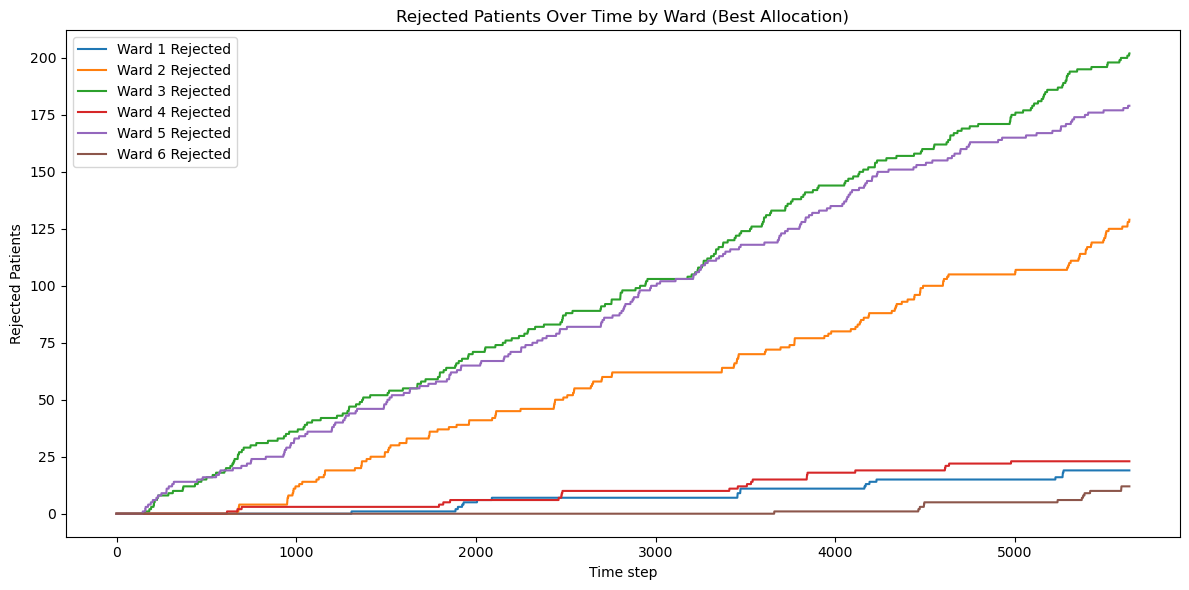

In [34]:
plt.figure(figsize=(12, 6))
for i in range(best_rej_hist.shape[1]):
    plt.plot(best_rej_hist[:, i], label=f"Ward {i+1} Rejected")
plt.xlabel("Time step")
plt.ylabel("Rejected Patients")
plt.title("Rejected Patients Over Time by Ward (Best Allocation)")
plt.legend()
plt.tight_layout()
plt.show()

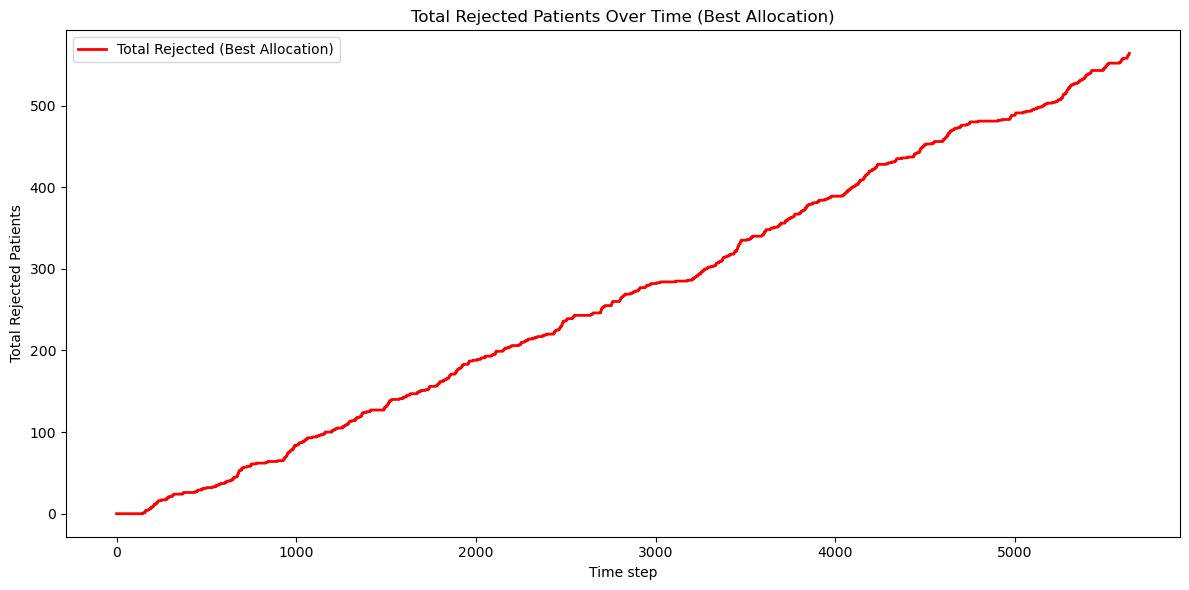

In [35]:
plt.figure(figsize=(12, 6))
total_rejected_best = best_rej_hist.sum(axis=1)
plt.plot(total_rejected_best, label="Total Rejected (Best Allocation)", color="red", linewidth=2)
plt.xlabel("Time step")
plt.ylabel("Total Rejected Patients")
plt.title("Total Rejected Patients Over Time (Best Allocation)")
plt.legend()
plt.tight_layout()
plt.show()

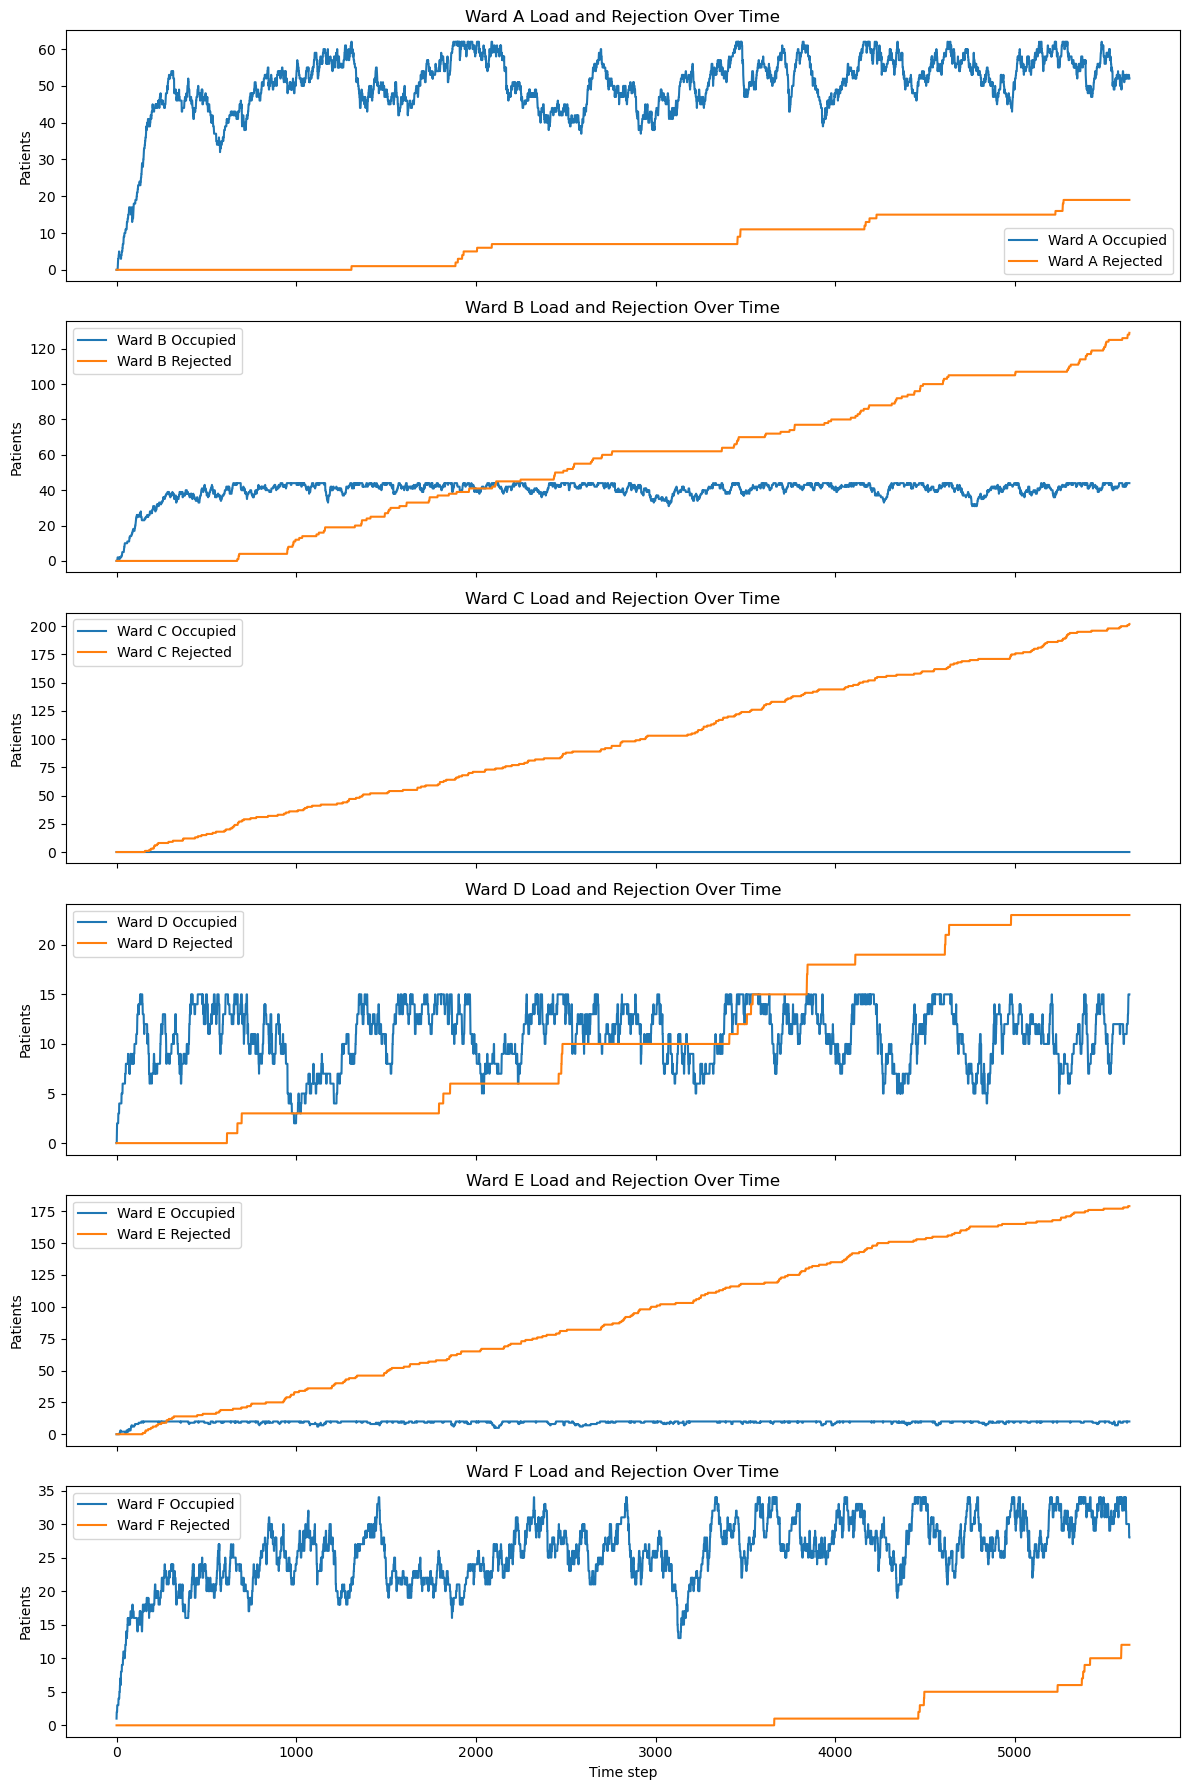

In [36]:
fig, axes = plt.subplots(6, 1, figsize=(12, 18), sharex=True)
ward_names = ['A', 'B', 'C', 'D', 'E', 'F']

for idx in range(6):
    axes[idx].plot(best_occ_bed_hist[:, idx], label=f'Ward {ward_names[idx]} Occupied')
    axes[idx].plot(best_rej_hist[:, idx], label=f'Ward {ward_names[idx]} Rejected')
    axes[idx].set_ylabel("Patients")
    axes[idx].set_title(f"Ward {ward_names[idx]} Load and Rejection Over Time")
    axes[idx].legend()

axes[-1].set_xlabel("Time step")
plt.tight_layout()
plt.show()

In [37]:
print(compute_empirical_transition(best_reloc_matrix))

[[0.         0.23076923 0.         0.23076923 0.53846154 0.        ]
 [0.52173913 0.         0.         0.31884058 0.15942029 0.        ]
 [0.38704028 0.2732049  0.         0.22241681 0.117338   0.        ]
 [0.57575758 0.3030303  0.         0.         0.12121212 0.        ]
 [0.53174603 0.24603175 0.         0.22222222 0.         0.        ]
 [0.39285714 0.17857143 0.         0.39285714 0.03571429 0.        ]]


In [38]:
best_reloc_matrix

array([[  0,   3,   0,   3,   7,   0],
       [ 36,   0,   0,  22,  11,   0],
       [221, 156,   0, 127,  67,   0],
       [ 19,  10,   0,   0,   4,   0],
       [ 67,  31,   0,  28,   0,   0],
       [ 11,   5,   0,  11,   1,   0]])